In [1]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 12.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import math
import imageio
import glob

## DataLoad & 전처리

In [3]:
class DiffSet(Dataset):
    def __init__(self, train, dataset="MNIST"):
        transform = transforms.Compose([transforms.ToTensor()])

        datasets = {
            "MNIST": MNIST,
            "Fashion": FashionMNIST,
            "CIFAR": CIFAR10,
        }

        train_dataset = datasets[dataset](
            "./data", download=True, train=train, transform=transform
        )

        self.dataset_len = len(train_dataset.data)

        if dataset == "MNIST" or dataset == "Fashion":
            pad = transforms.Pad(2) #각 이미지의 각 측면에 2씩 패딩 추가
            data = pad(train_dataset.data) #28 X 28 -> 32X 32
            data = data.unsqueeze(3) # 텐서의 끝에 차원을 추가하여 ( N, 32, 32 ) -> ( N, 32, 32 ,1 ) , 흑백 이미지 임을 나타내기 위해서
            self.depth = 1 # 흑백이미지
            self.size = 32
        elif dataset == "CIFAR":
            data = torch.Tensor(train_dataset.data)
            self.depth = 3
            self.size = 32
        self.input_seq = ((data / 255.0) * 2.0) - 1.0 # 픽셀 0~255 에서 -1 ~ 1 로 정규화
        self.input_seq = self.input_seq.moveaxis(3, 1) #( N, 32, 32 ,1 ) 에서 ( N, 1, 32, 32  ) 로 변경

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, item):
        return self.input_seq[item]


In [4]:
class SelfAttention(nn.Module):
    def __init__(self, h_size):
        super(SelfAttention, self).__init__()
        self.h_size = h_size
        self.mha = nn.MultiheadAttention(h_size, 4, batch_first=True)
        self.ln = nn.LayerNorm([h_size])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([h_size]),
            nn.Linear(h_size, h_size),
            nn.GELU(),
            nn.Linear(h_size, h_size),
        )

    def forward(self, x):
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value


class SAWrapper(nn.Module):
    def __init__(self, h_size, num_s):
        super(SAWrapper, self).__init__()
        self.sa = nn.Sequential(*[SelfAttention(h_size) for _ in range(1)])
        self.num_s = num_s
        self.h_size = h_size

    def forward(self, x):
        x = x.view(-1, self.h_size, self.num_s * self.num_s).swapaxes(1, 2)
        x = self.sa(x)
        x = x.swapaxes(2, 1).view(-1, self.h_size, self.num_s, self.num_s)
        return x


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels # 지정되지 않은 경우 out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False), # 이미지 크기 그대로
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False), # 이미지 크기 그대로
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual: #residual 할때
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), # 이미지 크기 1/2
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True) # 이미지 크기를 2배로 늘림
            self.conv = DoubleConv(in_channels, in_channels, residual=True)
            self.conv2 = DoubleConv(in_channels, out_channels, in_channels // 2) # channels수 반으로 줄임
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2 # 이미지 크기 2배로 늘림
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        x = self.conv2(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [5]:
class DiffusionModel(pl.LightningModule):
    def __init__(self, in_size, t_range, img_depth):
        super().__init__()
        self.beta_small = 1e-4
        self.beta_large = 0.02
        self.t_range = t_range
        self.in_size = in_size

        bilinear = True
        self.inc = DoubleConv(img_depth, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, img_depth)
        self.sa1 = SAWrapper(256, 8)
        self.sa2 = SAWrapper(256, 4)
        self.sa3 = SAWrapper(128, 8)

    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size) #embed_size는 width x height [batchsize,channels,embed_size,embed_size]

    def forward(self, x, t):
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4)
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32)
        output = self.outc(x)
        return output

    #t가 0일 때는 self.beta_small 값을 가지고, t가 self.t_range에 가까워질수록 self.beta_large에 가까워짐
    def beta(self, t):
        return self.beta_small + (t / self.t_range) * (
            self.beta_large - self.beta_small
        )

    # alpha= 1- beta
    def alpha(self, t):
        return 1 - self.beta(t)

    # 시간 단계 t까지의 모든 알파 값의 곱을 계산
    def alpha_bar(self, t):
        alphas = [self.alpha(torch.tensor(j, device=self.device)) for j in range(int(t))]
        return torch.prod(torch.tensor(alphas))


    def get_loss(self, batch, batch_idx):
        ts = torch.randint(0, self.t_range, [batch.shape[0]], device=self.device)
        noise_imgs = []
        epsilons = torch.randn(batch.shape, device=self.device) #배치와 동일한 shape를 가진 random noise
        for i in range(len(ts)):
            a_hat = self.alpha_bar(ts[i].item())
            noise_imgs.append(
                (math.sqrt(a_hat) * batch[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
            ) # 노이즈가 추가된 이미지 생성
        noise_imgs = torch.stack(noise_imgs, dim=0)
        e_hat = self.forward(noise_imgs, ts.unsqueeze(-1).type(torch.float)) # 노이즈가 추가된 이미지를 모델에 입력했을때, 모델이 예측한 노이즈값
        loss = nn.functional.mse_loss(
            e_hat.reshape(-1, self.in_size), epsilons.reshape(-1, self.in_size)
        ) #  모델의 예측 노이즈와 실제 노이즈간의 mse 계산
        return loss

    def denoise_sample(self, x, t):
      with torch.no_grad():
        if t > 1:
            z = torch.randn(x.shape, device=x.device) #입력값과 동일한 shape를 가진 랜덤 노이즈 생성
        else:
            z = 0
        t = t.to(x.device)  # t 텐서를 x 텐서와 동일한 장치로 이동
        e_hat = self.forward(x, t.view(1, 1).repeat(x.shape[0], 1)) # 모델의 예측값, 노이즈값

        # 노이즈를 활용하여 노이즈 제거하여 이미지 복원
        pre_scale = 1 / math.sqrt(self.alpha(t))
        e_scale = (1 - self.alpha(t)) / math.sqrt(1 - self.alpha_bar(t))
        post_sigma = math.sqrt(self.beta(t)) * z
        x = pre_scale * (x - e_scale * e_hat) + post_sigma

        return x

    def training_step(self, batch, batch_idx):
        loss = self.get_loss(batch, batch_idx)
        self.log("train/loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.get_loss(batch, batch_idx)
        self.log("val/loss", loss)
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return optimizer

In [6]:
diffusion_steps = 1000
dataset_choice = "MNIST"
max_epoch = 10
batch_size = 128

# Loading parameters
load_model = False
load_version_num = 1

In [7]:
# Code for optionally loading model
pass_version = None
last_checkpoint = None

if load_model:
    pass_version = load_version_num
    last_checkpoint = glob.glob(
        f"./lightning_logs/{dataset_choice}/version_{load_version_num}/checkpoints/*.ckpt"
    )[-1]

In [8]:
# Create datasets and data loaders
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(False, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

# Create model and trainer
if load_model:
    model = DiffusionModel.load_from_checkpoint(last_checkpoint, in_size=train_dataset.size*train_dataset.size, t_range=diffusion_steps, img_depth=train_dataset.depth)
else:
    model = DiffusionModel(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15870142.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 476760.14it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4394725.35it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4983135.96it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
# Load Trainer model
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)

# Trainer 설정
trainer = pl.Trainer(
    max_epochs=max_epoch,
    log_every_n_steps=10,
    accelerator='gpu',  # 'gpu' 대신 'auto'를 사용할 수도 있음
    devices=1,  # 사용할 GPU 수
    # resume_from_checkpoint=last_checkpoint,
    logger=tb_logger
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [12]:
# Train model
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name  | Type       | Params | Mode 
----------------------------------------------
0  | inc   | DoubleConv | 37.7 K | train
1  | down1 | Down       | 295 K  | train
2  | down2 | Down       | 1.2 M  | train
3  | down3 | Down       | 2.4 M  | train
4  | up1   | Up         | 6.2 M  | train
5  | up2   | Up         | 1.5 M  | train
6  | up3   | Up         | 406 K  | train
7  | outc  | OutConv    | 65     | train
8  | sa1   | SAWrapper  | 395 K  | train
9  | sa2   | SAWrapper  | 395 K  | train
10 | sa3   | SAWrapper  | 99.6 K | train
----------------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.676    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


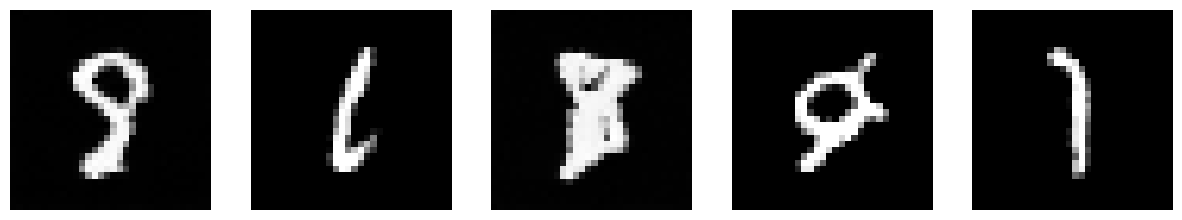

In [31]:
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import glob

# 모델 로드 설정
load_version_num = 1  # 로드할 모델 버전 번호
dataset_choice = "MNIST"  # 데이터셋 선택
last_checkpoint = glob.glob(
    f"/content/lightning_logs/MNIST/version_0/checkpoints/epoch=9-step=4690.ckpt"
)[-1]


# 모델 로드
model = DiffusionModel.load_from_checkpoint(last_checkpoint, in_size=32*32, t_range=1000, img_depth=1)  # in_size와 img_depth는 데이터셋에 맞게 조정

# 샘플링 함수
def sample_images(model, num_samples=5, diffusion_steps=1000, img_size=32, img_depth=1):
    model.eval()
    with torch.no_grad():
        samples = torch.randn((num_samples, img_depth, img_size, img_size), device=model.device)
        for t in range(diffusion_steps, 0, -1):
            t_tensor = torch.tensor([t], device=model.device, dtype=torch.float32).view(1, 1)
            samples = model.denoise_sample(samples, t_tensor)
        samples = (samples.clamp(-1, 1) + 1) / 2
        samples = samples.cpu().numpy()
        return samples

# 샘플링
num_samples = 5  # 생성할 샘플 수
samples = sample_images(model, num_samples=num_samples, diffusion_steps=1000, img_size=32, img_depth=1)

# 샘플 이미지 출력
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axes[i].imshow(samples[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()
